In [1]:
%pip install langchain openai scikit-learn langchain-community kaggle


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Get the OpenAI API key
import os
from dotenv import load_dotenv

# Try to load from .env file
load_dotenv()

# If not found in .env, try to get from Google Colab
if "OPENAI_API_KEY" not in os.environ:
    try:
        from google.colab import userdata
        api_key = userdata.get('OPENAI_API_KEY')
        if api_key:
            os.environ["OPENAI_API_KEY"] = api_key
    except ImportError:
        pass

if "OPENAI_API_KEY" not in os.environ:
    raise ValueError("OpenAI API key not found. Please set it in .env file or Google Colab secrets.")

Dataset URL: https://www.kaggle.com/datasets/jabara/freud-detection
Test dataset head:
                                               quote author  freud
0             America is a mistake, a giant mistake.  Freud      1
1  The intention that man should be happy is not ...  Freud      1
2  My love is something valuable to me which I ou...  Freud      1
3  Men are more moral than they think and far mor...  Freud      1
4  A man should not strive to eliminate his compl...  Freud      1

Train dataset head:
                                               quote author  freud
0  One day, in retrospect, the years of struggle ...  Freud      1
1  Being entirely honest with oneself is a good e...  Freud      1
2  Unexpressed emotions will never die. They are ...  Freud      1
3  Most people do not really want freedom, becaus...  Freud      1
4  We are never so defenseless against suffering ...  Freud      1

Test dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 3

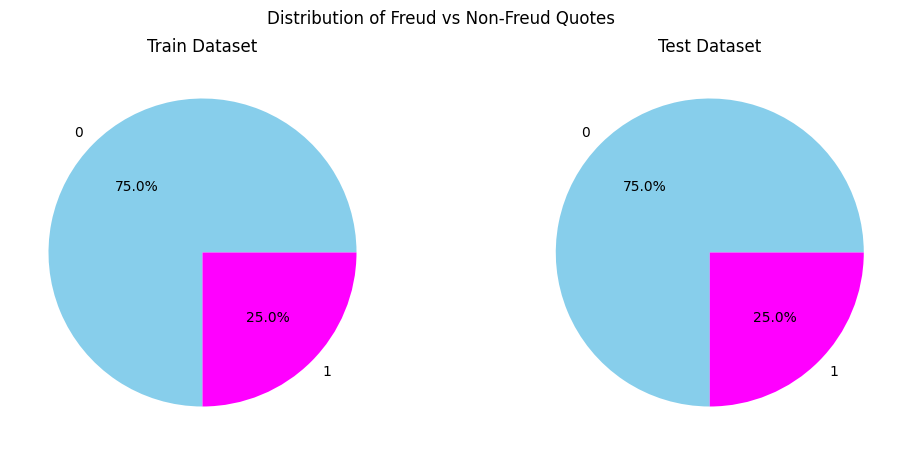

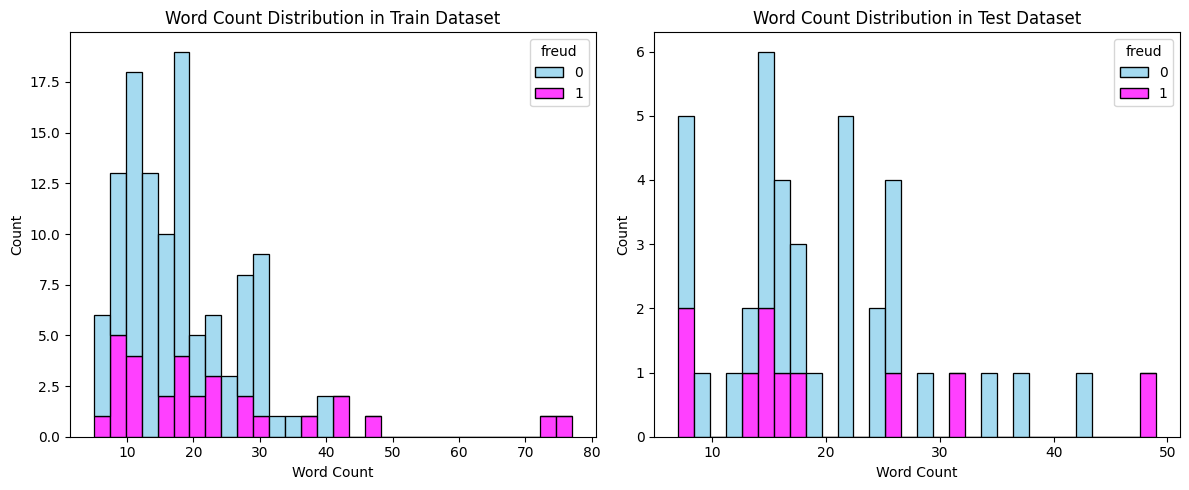


Example Freud quotes:
0    One day, in retrospect, the years of struggle ...
1    Being entirely honest with oneself is a good e...
2    Unexpressed emotions will never die. They are ...
3    Most people do not really want freedom, becaus...
4    We are never so defenseless against suffering ...
Name: quote, dtype: object

Example non-Freud quotes:
30    The person, be it gentleman or lady, who has n...
31    There is nothing I would not do for those who ...
32       The distance is nothing when one has a motive.
33    In vain have I struggled. It will not do. My f...
34    A lady's imagination is very rapid; it jumps f...
Name: quote, dtype: object


In [3]:
import kaggle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Download the dataset
kaggle.api.dataset_download_files('jabara/freud-detection', path='./data', unzip=True)
test  = pd.read_csv('./data/Freud_Detection_Test.csv')
train = pd.read_csv('./data/Freud_Detection_Train.csv')

# Define custom colors
sky_blue = '#87CEEB'
fuchsia = '#FF00FF'

# Create a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom", [sky_blue, fuchsia])

# Display the first few rows of each dataset
print("Test dataset head:")
print(test.head())
print("\nTrain dataset head:")
print(train.head())

# Basic info about the datasets
print("\nTest dataset info:")
print(test.info())
print("\nTrain dataset info:")
print(train.info())

# Distribution of Freud vs non-Freud quotes in both datasets
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train['freud'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   colors=[sky_blue, fuchsia], 
                                   title='Train Dataset')
plt.ylabel('')

plt.subplot(1, 2, 2)
test['freud'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                  colors=[sky_blue, fuchsia], 
                                  title='Test Dataset')
plt.ylabel('')

plt.suptitle('Distribution of Freud vs Non-Freud Quotes')
plt.show()

# Word count distribution
train['word_count'] = train['quote'].str.split().str.len()
test['word_count'] = test['quote'].str.split().str.len()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=train, x='word_count', hue='freud', multiple='stack', 
             bins=30, palette={0: sky_blue, 1: fuchsia})
plt.title('Word Count Distribution in Train Dataset')
plt.xlabel('Word Count')

plt.subplot(1, 2, 2)
sns.histplot(data=test, x='word_count', hue='freud', multiple='stack', 
             bins=30, palette={0: sky_blue, 1: fuchsia})
plt.title('Word Count Distribution in Test Dataset')
plt.xlabel('Word Count')

plt.tight_layout()
plt.show()

# Display some example quotes
print("\nExample Freud quotes:")
print(train[train['freud'] == 1]['quote'].head())
print("\nExample non-Freud quotes:")
print(train[train['freud'] == 0]['quote'].head())

In [4]:
import json
import os

def create_fine_tuning_data(df):
    fine_tuning_data = []
    
    for _, row in df.iterrows():
        example = {
            "messages": [
                {
                    "role": "user",
                    "content": f"""Given the following quote, determine if it was said by Sigmund Freud.
Answer with either 'Yes' or 'No'.

Quote: {row['quote']}

Was this quote by Sigmund Freud?"""
                },
                {
                    "role": "assistant",
                    "content": "Yes" if row['freud'] == 1 else "No"
                }
            ]
        }
        fine_tuning_data.append(example)
    
    return fine_tuning_data

# Ensure the data directory exists
os.makedirs('data', exist_ok=True)

# Create and save training data
train_data = create_fine_tuning_data(train)
with open('data/freud_detector_train.jsonl', 'w') as f:
    for item in train_data:
        f.write(json.dumps(item) + '\n')

print(f"Training data saved to 'data/freud_detector_train.jsonl' with {len(train_data)} examples.")

# Create and save test data
test_data = create_fine_tuning_data(test)
with open('data/freud_detector_test.jsonl', 'w') as f:
    for item in test_data:
        f.write(json.dumps(item) + '\n')

print(f"Test data saved to 'data/freud_detector_test.jsonl' with {len(test_data)} examples.")

# Print the first example from training data to verify the format
print("\nFirst example in the training data:")
print(json.dumps(train_data[0], indent=2))

Training data saved to 'data/freud_detector_train.jsonl' with 120 examples.
Test data saved to 'data/freud_detector_test.jsonl' with 40 examples.

First example in the training data:
{
  "messages": [
    {
      "role": "user",
      "content": "Given the following quote, determine if it was said by Sigmund Freud.\nAnswer with either 'Yes' or 'No'.\n\nQuote: One day, in retrospect, the years of struggle will strike you as the most beautiful.\n\nWas this quote by Sigmund Freud?"
    },
    {
      "role": "assistant",
      "content": "Yes"
    }
  ]
}


Classifying quotes with gpt-4o-mini: 100%|██████████| 40/40 [00:13<00:00,  3.05it/s]

Accuracy on test set with gpt-4o-mini: 0.82


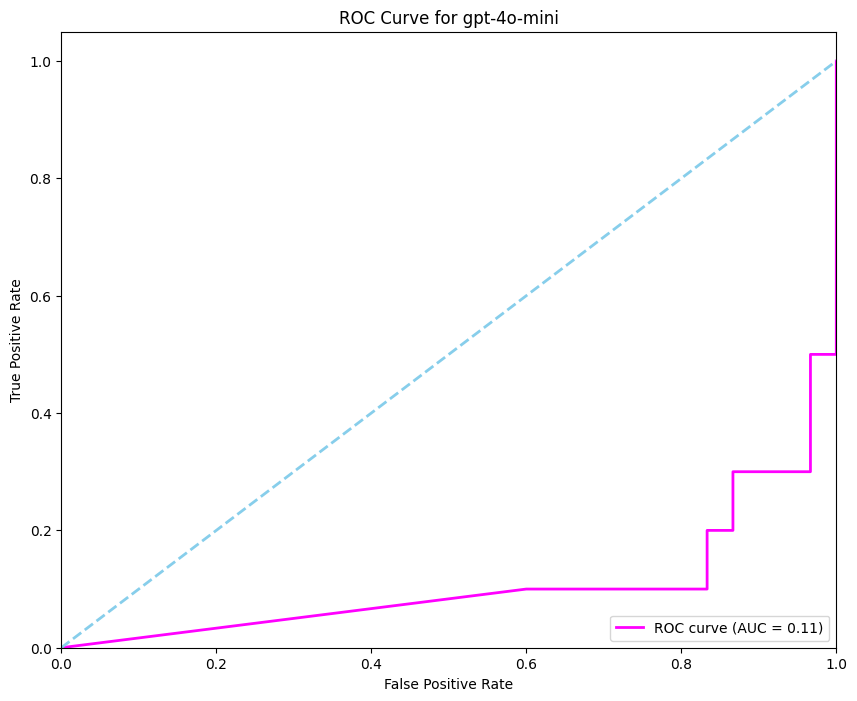

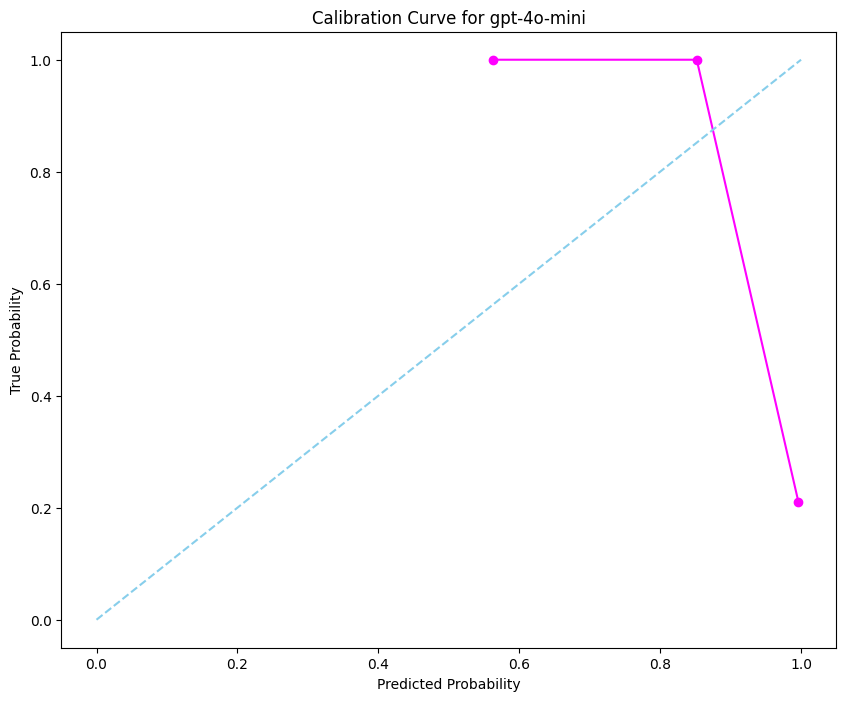

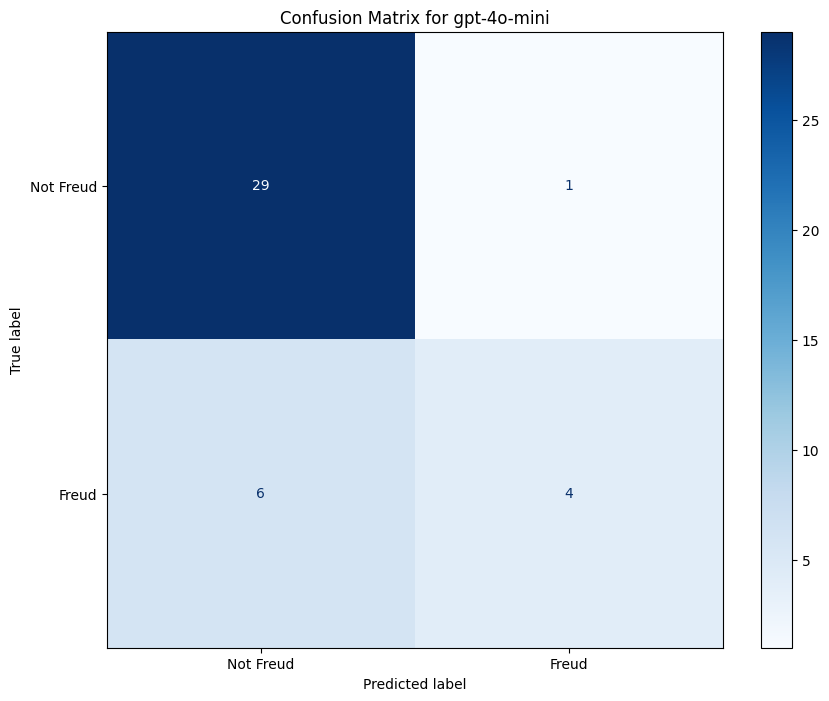

              precision    recall  f1-score   support

   Not Freud       0.83      0.97      0.89        30
       Freud       0.80      0.40      0.53        10

    accuracy                           0.82        40
   macro avg       0.81      0.68      0.71        40
weighted avg       0.82      0.82      0.80        40



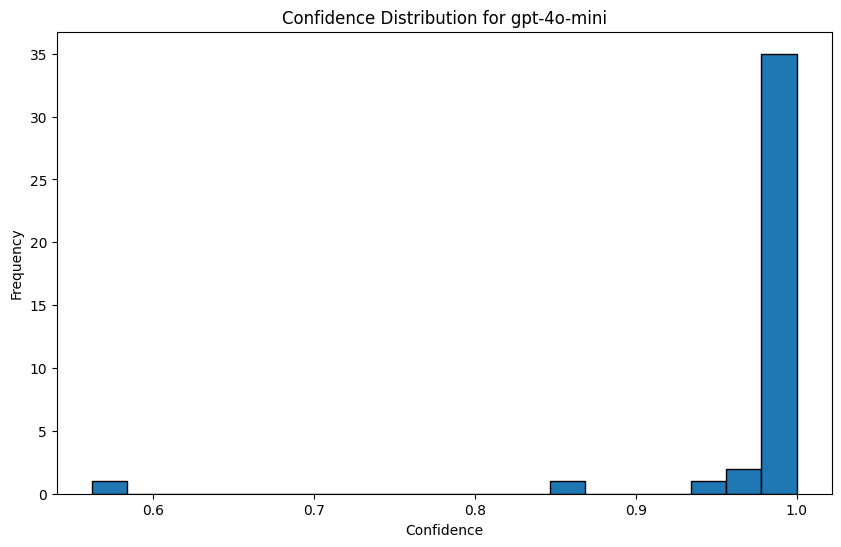


Confidence statistics for gpt-4o-mini:
count    40.000000
mean      0.981771
std       0.072745
min       0.562177
25%       0.999998
50%       1.000000
75%       1.000000
max       1.000000
Name: confidence, dtype: float64

Confidence distribution:
confidence
(0.562, 0.606]     1
(0.606, 0.65]      0
(0.65, 0.694]      0
(0.694, 0.737]     0
(0.737, 0.781]     0
(0.781, 0.825]     0
(0.825, 0.869]     1
(0.869, 0.912]     0
(0.912, 0.956]     1
(0.956, 1.0]      37
Name: count, dtype: int64

Sample predictions:
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 1.0, Predicted: 1.0, Confidence: 0.5622
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 1.0, Predicted: 1.0, Confidence: 0.9627

Classification Repor

Classifying quotes with ft:gpt-4o-mini-2024-07-18:anthus-ai-solutions:freud-detector:A2TjsD0q: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]

Accuracy on test set with ft:gpt-4o-mini-2024-07-18:anthus-ai-solutions:freud-detector:A2TjsD0q: 0.93


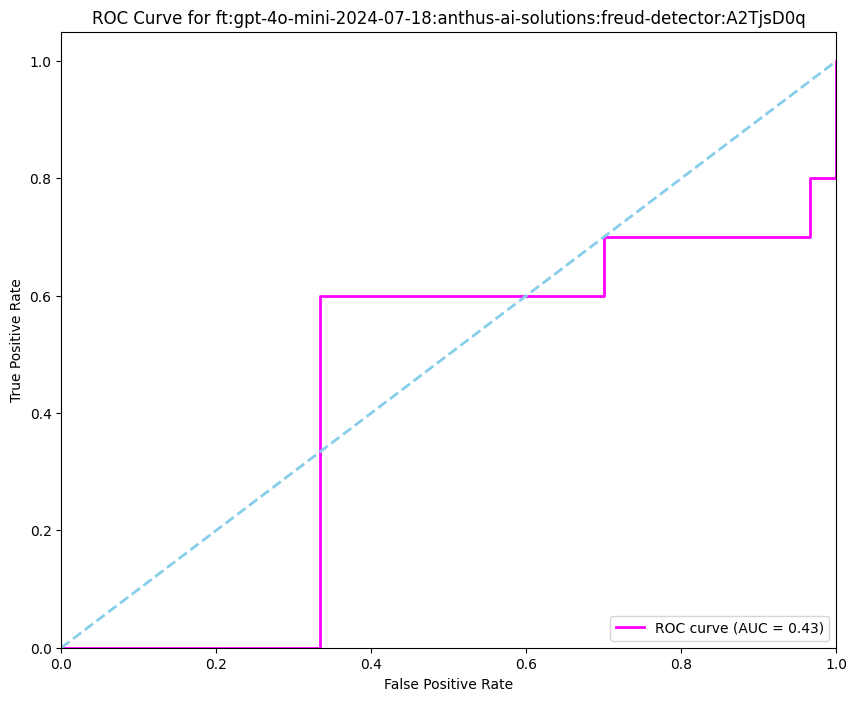

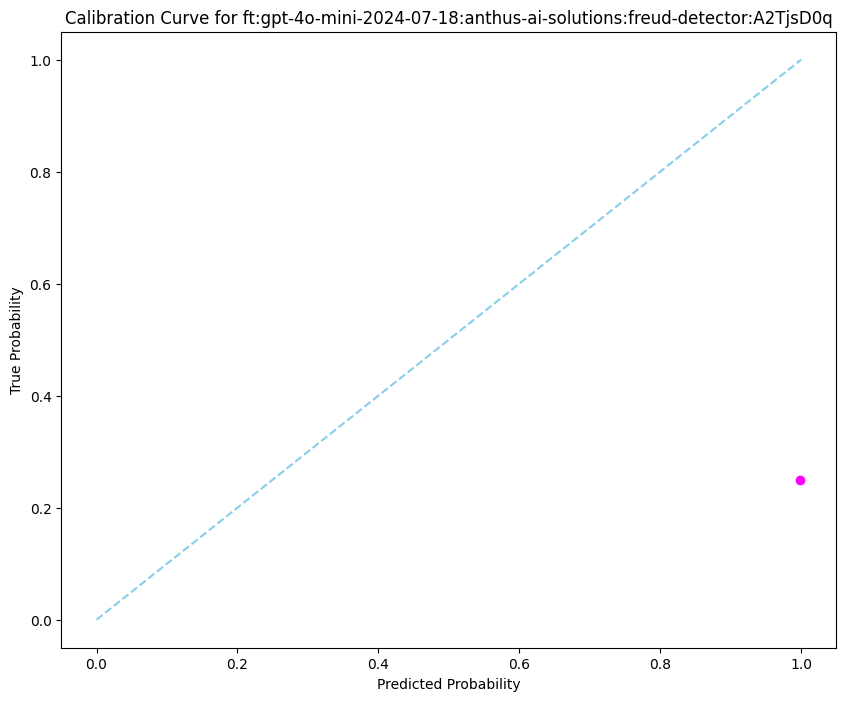

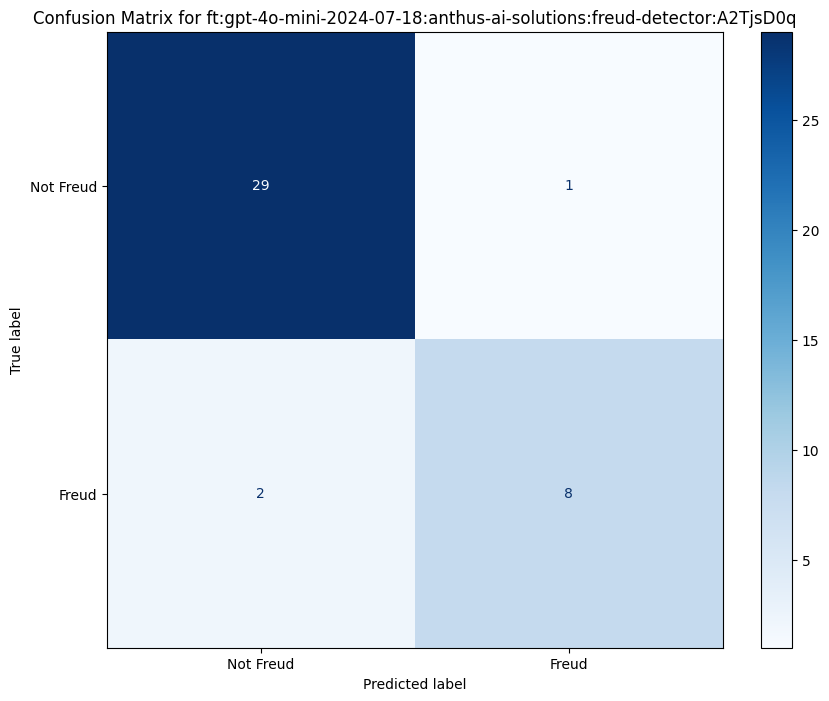

              precision    recall  f1-score   support

   Not Freud       0.94      0.97      0.95        30
       Freud       0.89      0.80      0.84        10

    accuracy                           0.93        40
   macro avg       0.91      0.88      0.90        40
weighted avg       0.92      0.93      0.92        40



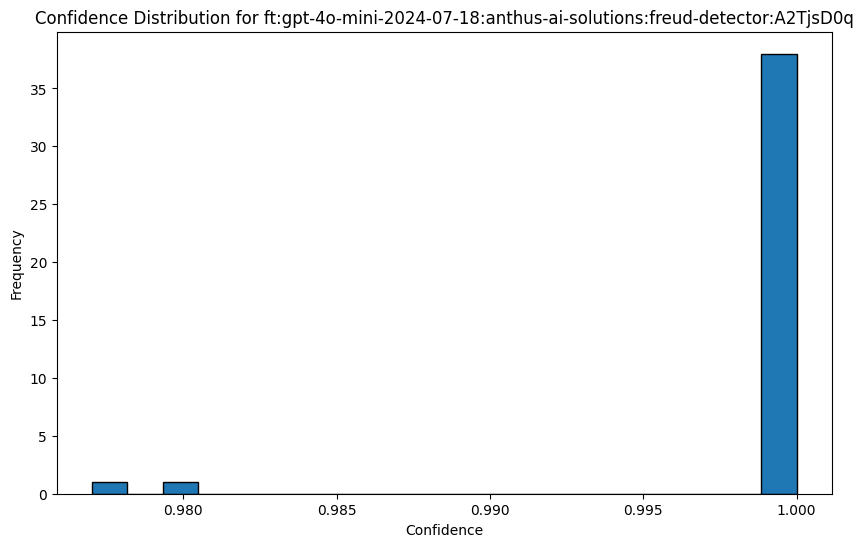


Confidence statistics for ft:gpt-4o-mini-2024-07-18:anthus-ai-solutions:freud-detector:A2TjsD0q:
count    40.000000
mean      0.998895
std       0.004784
min       0.977023
25%       0.999972
50%       0.999985
75%       1.000000
max       1.000000
Name: confidence, dtype: float64

Confidence distribution:
confidence
(0.977, 0.979]     1
(0.979, 0.982]     1
(0.982, 0.984]     0
(0.984, 0.986]     0
(0.986, 0.989]     0
(0.989, 0.991]     0
(0.991, 0.993]     0
(0.993, 0.995]     0
(0.995, 0.998]     0
(0.998, 1.0]      38
Name: count, dtype: int64

Sample predictions:
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 1.0, Predicted: 1.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 0.0, Predicted: 0.0, Confidence: 1.0000
True: 1.0

In [7]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.calibration import calibration_curve

# Define custom colors
sky_blue = '#87CEEB'
fuchsia = '#FF00FF'

class FreudClassifier:
    def __init__(self, model_name):
        self.llm = ChatOpenAI(model=model_name).bind(logprobs=True, top_logprobs=3)
    
    def classify(self, quote):
        prompt = f"""Given the following quote, determine if it was said by Sigmund Freud.
        Answer with either 'Yes' or 'No'.
        
        Quote: {quote}
        
        Was this quote by Sigmund Freud?"""
        
        response = self.llm.invoke([HumanMessage(content=prompt)])
        
        # Extract the logprobs from response_metadata
        logprobs = response.response_metadata['logprobs']['content'][0]['top_logprobs']
        
        # Get the probabilities for 'Yes' and 'No'
        yes_prob = np.exp(next((item['logprob'] for item in logprobs if item['token'] == 'Yes'), float('-inf')))
        no_prob = np.exp(next((item['logprob'] for item in logprobs if item['token'] == 'No'), float('-inf')))
        
        # Normalize probabilities
        total_prob = yes_prob + no_prob
        yes_prob /= total_prob
        no_prob /= total_prob
        
        # Determine classification and confidence
        if yes_prob > no_prob:
            classification = 1  # Freud
            confidence = yes_prob
        else:
            classification = 0  # Not Freud
            confidence = no_prob
        
        return classification, confidence

def evaluate_model(model_name, test_data):
    classifier = FreudClassifier(model_name)
    
    classifications = []
    confidences = []
    for quote in tqdm(test_data['quote'], desc=f"Classifying quotes with {model_name}"):
        classification, confidence = classifier.classify(quote)
        classifications.append(classification)
        confidences.append(confidence)
    
    test_data['predicted_freud'] = classifications
    test_data['confidence'] = confidences
    
    # Calculate and print accuracy
    accuracy = (test_data['predicted_freud'] == test_data['freud']).mean()
    print(f"Accuracy on test set with {model_name}: {accuracy:.2f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(test_data['freud'], test_data['confidence'])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color=fuchsia, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color=sky_blue, lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot calibration curve
    prob_true, prob_pred = calibration_curve(test_data['freud'], test_data['confidence'], n_bins=10)
    
    plt.figure(figsize=(10, 8))
    plt.plot(prob_pred, prob_true, marker='o', color=fuchsia)
    plt.plot([0, 1], [0, 1], linestyle='--', color=sky_blue)
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title(f'Calibration Curve for {model_name}')
    plt.show()
    
    # Create and plot confusion matrix
    cm = confusion_matrix(test_data['freud'], test_data['predicted_freud'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Freud', 'Freud'])
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # Print classification report
    print(classification_report(test_data['freud'], test_data['predicted_freud'], target_names=['Not Freud', 'Freud']))
    
    # After calculating classifications and confidences
    results_df = pd.DataFrame({
        'true_label': test_data['freud'],
        'predicted_label': classifications,
        'confidence': confidences
    })

    # Histogram of confidences
    plt.figure(figsize=(10, 6))
    plt.hist(results_df['confidence'], bins=20, edgecolor='black')
    plt.title(f'Confidence Distribution for {model_name}')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.show()

    # Scatter plot of confidences (removed)

    # Move printed report to the end
    print(f"\nConfidence statistics for {model_name}:")
    print(results_df['confidence'].describe())

    print("\nConfidence distribution:")
    print(pd.cut(results_df['confidence'], bins=10).value_counts().sort_index())

    print("\nSample predictions:")
    samples = results_df.sample(n=min(10, len(results_df)))
    for _, row in samples.iterrows():
        print(f"True: {row['true_label']}, Predicted: {row['predicted_label']}, Confidence: {row['confidence']:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_data['freud'], test_data['predicted_freud'], target_names=['Not Freud', 'Freud']))

# Evaluate the base model
evaluate_model("gpt-4o-mini", test)

# Evaluate the fine-tuned model
evaluate_model("ft:gpt-4o-mini-2024-07-18:anthus-ai-solutions:freud-detector:A2TjsD0q", test)